In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

In [10]:
# Load the dataset
csv_path = "C:\\Users\\youse\\Downloads\\Aquifer_Petrignano.csv"
aquifer_data = pd.read_csv(csv_path, parse_dates=['Date'], dayfirst=True)
print(aquifer_data.head())

        Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
0 2009-07-28                    0.0                    -28.90   
1 2015-06-21                    0.0                    -20.79   
2 2019-10-10                    0.0                    -27.36   
3 2011-12-09                    0.0                    -27.78   
4 2011-09-20                    1.0                    -26.09   

   Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  Temperature_Petrignano  \
0                    -28.12                      27.4                    25.6   
1                    -20.45                      20.8                     0.0   
2                    -26.75                      20.3                    20.0   
3                    -26.98                       9.2                     8.8   
4                    -25.55                      15.7                    15.7   

   Volume_C10_Petrignano  Hydrometry_Fiume_Chiascio_Petrignano  
0             -34833.888                                 

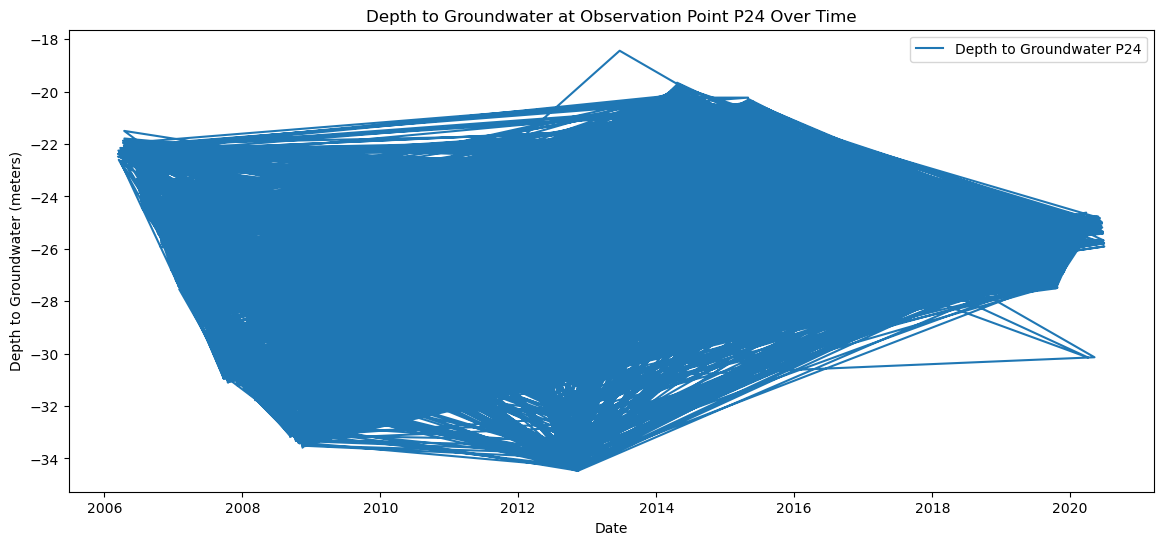

In [11]:
# Plot time series data for 'Depth_to_Groundwater_P24'
plt.figure(figsize=(14, 6))
plt.plot(aquifer_data['Date'], aquifer_data['Depth_to_Groundwater_P24'], label='Depth to Groundwater P24')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater (meters)')
plt.title('Depth to Groundwater at Observation Point P24 Over Time')
plt.legend()
plt.show()

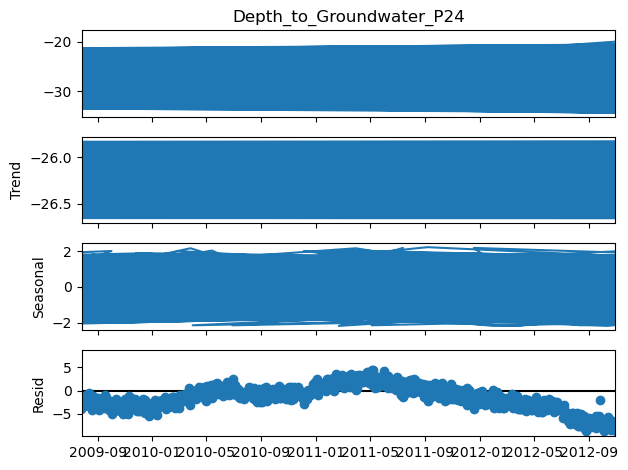

In [12]:
# Seasonal Decomposition
decomposition = seasonal_decompose(aquifer_data.set_index('Date')['Depth_to_Groundwater_P24'].dropna(), model='additive', period=365)
decomposition.plot()
plt.show()


In [13]:
# Data Preprocessing
aquifer_data.fillna(method='ffill', inplace=True)
aquifer_data.set_index('Date', inplace=True)
aquifer_data = aquifer_data.sort_index()
print(aquifer_data.isna().sum())  


Rainfall_Bastia_Umbra                   0
Depth_to_Groundwater_P24                0
Depth_to_Groundwater_P25                0
Temperature_Bastia_Umbra                0
Temperature_Petrignano                  0
Volume_C10_Petrignano                   0
Hydrometry_Fiume_Chiascio_Petrignano    0
dtype: int64


In [14]:
# Feature Engineering
aquifer_data['Prev_Depth_to_Groundwater_P24'] = aquifer_data['Depth_to_Groundwater_P24'].shift(1)
aquifer_data['DayOfWeek'] = aquifer_data.index.dayofweek
aquifer_data['Month'] = aquifer_data.index.month
aquifer_data['DayOfYear'] = aquifer_data.index.dayofyear
aquifer_data['IsWeekend'] = aquifer_data['DayOfWeek'] >= 5
aquifer_data['Diff_Depth_to_Groundwater_P24'] = aquifer_data['Depth_to_Groundwater_P24'].diff()
aquifer_data.dropna(inplace=True)
print(aquifer_data.head())

            Rainfall_Bastia_Umbra  Depth_to_Groundwater_P24  \
Date                                                          
2006-03-15                    0.0                    -22.38   
2006-03-16                    0.0                    -22.25   
2006-03-17                    0.0                    -22.38   
2006-03-18                   11.3                    -22.60   
2006-03-19                    0.0                    -22.35   

            Depth_to_Groundwater_P25  Temperature_Bastia_Umbra  \
Date                                                             
2006-03-15                    -22.14                      27.6   
2006-03-16                    -22.04                       6.5   
2006-03-17                    -22.04                      23.8   
2006-03-18                    -22.04                       9.8   
2006-03-19                    -21.95                      28.3   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                              

In [15]:
# Train-Test Split
X = aquifer_data.drop(columns=['Depth_to_Groundwater_P24'])
y = aquifer_data['Depth_to_Groundwater_P24']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6315.081, Time=6.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7756.932, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6676.007, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6398.998, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7754.945, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6393.196, Time=2.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6315.092, Time=3.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6316.640, Time=5.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6246.121, Time=13.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6311.371, Time=4.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6318.622, Time=6.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=6314.011, Time=7.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6310.708, Time=5.88 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=6242.282, Time=11.62 sec
 ARIMA(4,1,4)(0,0,0)[0] interce

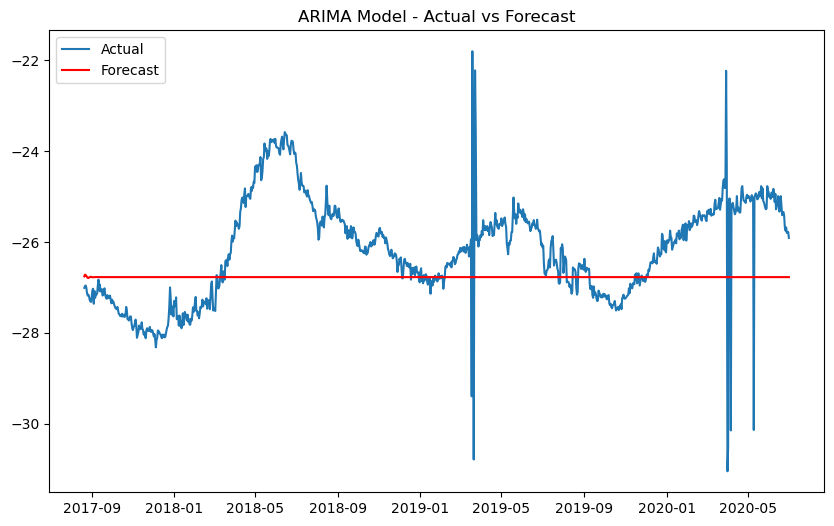

In [21]:

# Model 1: ARIMA
model_arima = pm.auto_arima(y_train, seasonal=False, trace=True)
model_arima.fit(y_train)
arima_forecast = model_arima.predict(n_periods=len(y_test))
mse_arima = mean_squared_error(y_test, arima_forecast)
print(f'ARIMA Model MSE: {mse_arima}')
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, arima_forecast, label='Forecast', color='red')
plt.title('ARIMA Model - Actual vs Forecast')
plt.legend()
plt.show()

c:\Users\youse\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 633.9657 - val_loss: 181.2485
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154.3790 - val_loss: 54.9964
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 55.9301 - val_loss: 16.6380
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.1073 - val_loss: 4.8101
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16.6661 - val_loss: 1.8373
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.6541 - val_loss: 1.3200
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.7018 - val_loss: 1.2687
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.8959 - val_loss: 1.2736
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.6932 - val_loss: 1.2737
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.6091 - val_loss: 1.2752
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.6856 - val_loss: 1.2687
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━

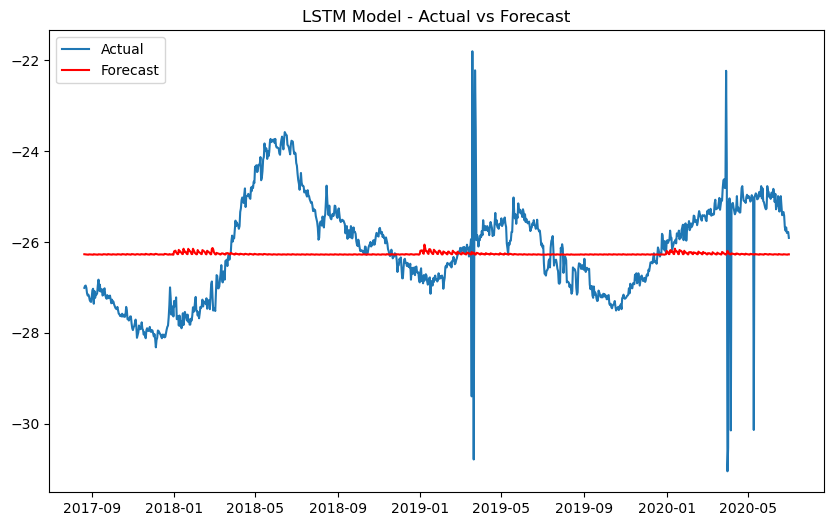

In [ ]:
# Model 2: LSTM
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)
lstm_forecast = model_lstm.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, lstm_forecast)
print(f'LSTM Model MSE: {mse_lstm}')
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, lstm_forecast, label='Forecast', color='red')
plt.title('LSTM Model - Actual vs Forecast')
plt.legend()
plt.show()